In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torchvision
!pip install datasets

from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.9 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


In [ ]:
!pip install --upgrade pyarrow

In [ ]:
!pip install --upgrade datasets

In [ ]:
from sklearn.model_selection import train_test_split

# Load and preprocess the pokemon dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # used by image net models
])

dataset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Rutgers/SCR', transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [ ]:
class_images = {}
idx_class = {value: key for key, value in dataset.class_to_idx.items()}

# Loop through the dataset
for data, target in dataset:
    if target not in class_images:
        class_images[target] = data

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


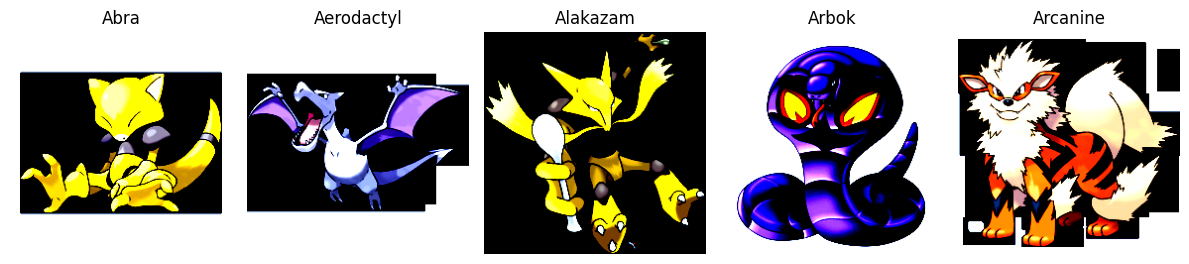

In [ ]:
import matplotlib.pyplot as plt

# Display the images
fig, axes = plt.subplots(1, 5, figsize=(12, 6))
axes = axes.flatten()


for idx, img in class_images.items():
    image = img.permute(1, 2, 0).numpy()
    label = idx_class[idx]

    axes[idx].imshow(image)
    axes[idx].set_title(label)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from transformers import ViTImageProcessor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
image_tensor = torch.tensor(image)  # Convert NumPy array to PyTorch tensor

# Clip the tensor values to be within [0, 1]
image_tensor = torch.clamp(image_tensor, 0, 1)

processor(image_tensor, return_tensors='pt')

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


{'pixel_values': tensor([[[[-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          ...,
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922]],

         [[-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          ...,
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922]],

         [[-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0

In [ ]:
def process_example(example):
    inputs = processor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [ ]:
import torch

# def collate_fn(batch):
#     return {
#         'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
#         'labels': torch.tensor([x['labels'] for x in batch])
#     }

def collate_fn(batch):
    images = []
    labels = []
    for image, label in batch:
        images.append(image)
        labels.append(label)
    return {
        'pixel_values': torch.stack(images),
        'labels': torch.tensor(labels)
    }

In [ ]:
!pip install --upgrade pyarrow

In [ ]:
import datasets

In [ ]:
from datasets import list_metrics
datasets.list_metrics()

In [ ]:
import numpy as np
from datasets import load_metric

# accuracy_metric = load_metric("accuracy")
# f1_metric = load_metric("f1")
# precision_metric = load_metric("precision")
# recall_metric = load_metric("recall")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Compute accuracy
    accuracy = (predictions.argmax(axis=1) == labels).mean().item()

    # Compute additional metrics
    # For example, you can compute precision, recall, F1-score, etc.
    precision = precision_score(labels, predictions.argmax(axis=1), average='macro')
    recall = recall_score(labels, predictions.argmax(axis=1), average='macro')
    f1 = f1_score(labels, predictions.argmax(axis=1), average='macro')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
!pip install transformers[torch]

In [ ]:
!pip install accelerate -U

EPOCHS: 4
LEARNING RATE: 2e-4

In [ ]:
from transformers import ViTForImageClassification
labels = dataset.classes

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset= train_dataset,
    eval_dataset= val_dataset,
    tokenizer=processor,
)

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9667
  eval_f1                 =     0.9684
  eval_loss               =     0.1569
  eval_precision          =     0.9713
  eval_recall             =     0.9679
  eval_runtime            = 0:00:02.54
  eval_samples_per_second =     35.388
  eval_steps_per_second   =      4.718


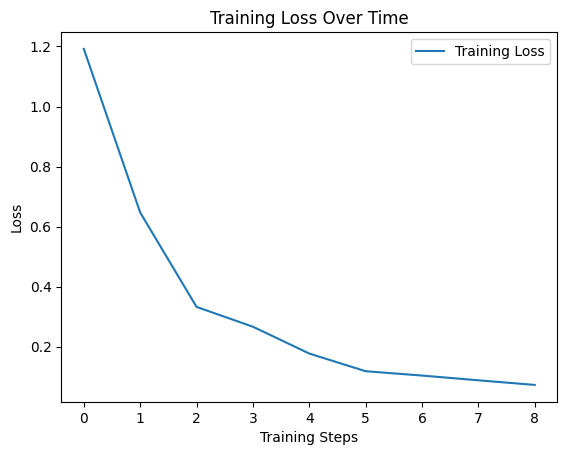

In [ ]:
import matplotlib.pyplot as plt

metrics = trainer.evaluate(val_dataset)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

# Accessing training metrics from the Trainer object
train_metrics = trainer.state.log_history

# Extract the training loss values from the training metrics if available
train_loss_values = [metrics.get('loss', None) for metrics in train_metrics]

# Filter out None values (e.g., if loss is not logged for some training steps)
train_loss_values = [loss for loss in train_loss_values if loss is not None]

# Plot the loss over time
plt.plot(train_loss_values, label='Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

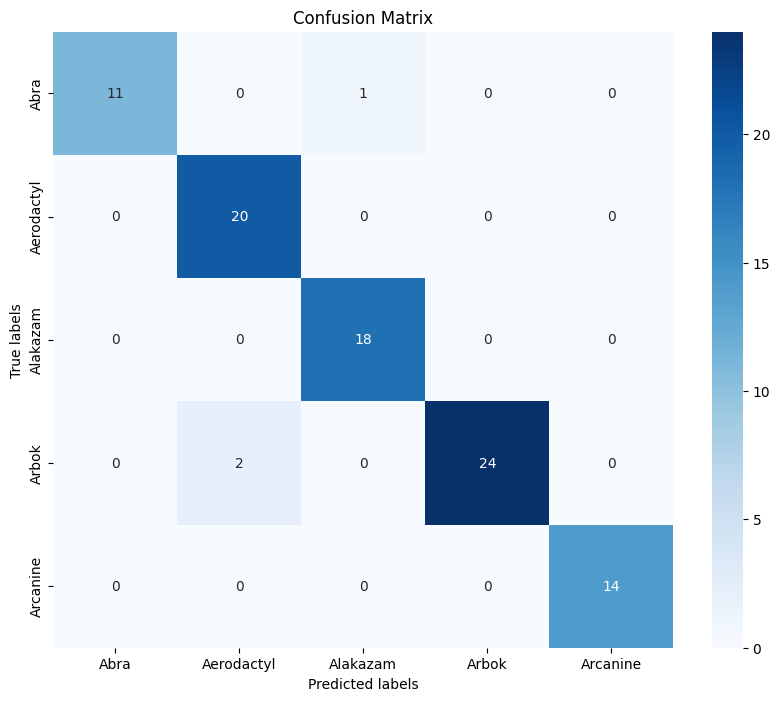

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions on the validation dataset
predictions = trainer.predict(val_dataset)

# Extract predicted labels
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Extract true labels
true_labels = [example[1] for example in val_dataset]

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


Epoch: 8
Learning Rate: 2e-4

In [ ]:
from transformers import ViTForImageClassification
labels = dataset.classes

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=8,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset= train_dataset,
    eval_dataset= val_dataset,
    tokenizer=processor,
)

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.058500,0.123476,0.966667,0.968485,0.973504,0.969865


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


***** train metrics *****
  epoch                    =         8.0
  total_flos               = 207855301GF
  train_loss               =      0.1809
  train_runtime            =  0:01:30.33
  train_samples_per_second =      31.882
  train_steps_per_second   =       2.037


***** eval metrics *****
  epoch                   =        8.0
  eval_accuracy           =     0.9667
  eval_f1                 =     0.9699
  eval_loss               =     0.1235
  eval_precision          =     0.9685
  eval_recall             =     0.9735
  eval_runtime            = 0:00:02.56
  eval_samples_per_second =     35.084
  eval_steps_per_second   =      4.678


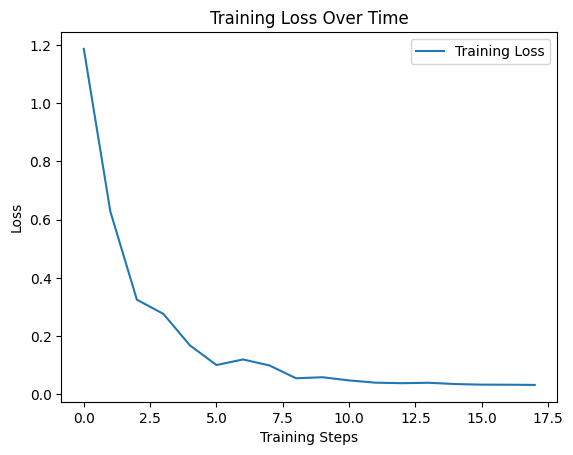

In [ ]:
import matplotlib.pyplot as plt

metrics = trainer.evaluate(val_dataset)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

# Accessing training metrics from the Trainer object
train_metrics = trainer.state.log_history

# Extract the training loss values from the training metrics if available
train_loss_values = [metrics.get('loss', None) for metrics in train_metrics]

# Filter out None values (e.g., if loss is not logged for some training steps)
train_loss_values = [loss for loss in train_loss_values if loss is not None]

# Plot the loss over time
plt.plot(train_loss_values, label='Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

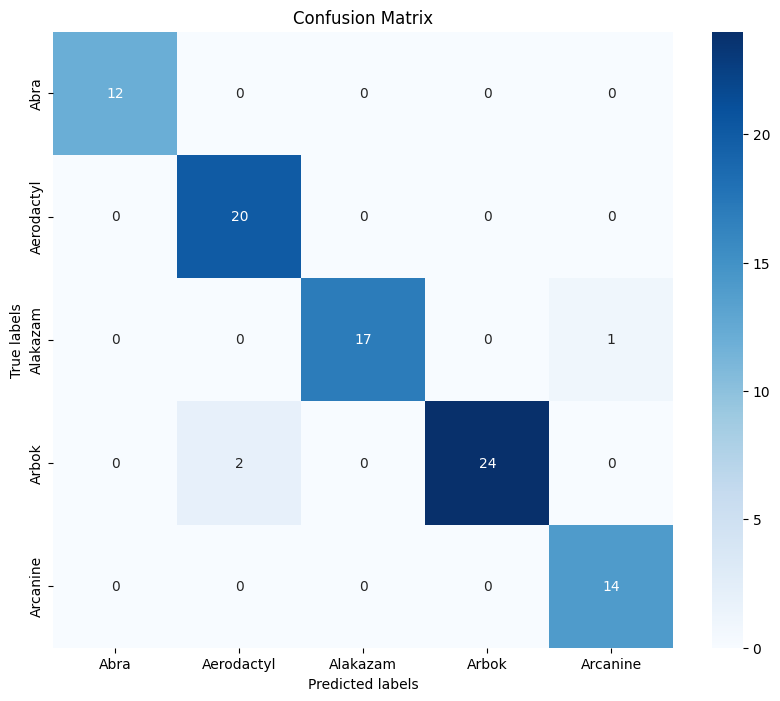

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions on the validation dataset
predictions = trainer.predict(val_dataset)

# Extract predicted labels
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Extract true labels
true_labels = [example[1] for example in val_dataset]

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Epoch: 4
Learning Rate: 2e-5

In [ ]:
from transformers import ViTForImageClassification
labels = dataset.classes

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=3e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset= train_dataset,
    eval_dataset= val_dataset,
    tokenizer=processor,
)

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 103927650GF
  train_loss               =      0.2724
  train_runtime            =  0:00:41.87
  train_samples_per_second =      34.386
  train_steps_per_second   =       2.197


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9667
  eval_f1                 =     0.9688
  eval_loss               =     0.1393
  eval_precision          =     0.9664
  eval_recall             =     0.9735
  eval_runtime            = 0:00:02.29
  eval_samples_per_second =     39.139
  eval_steps_per_second   =      5.218


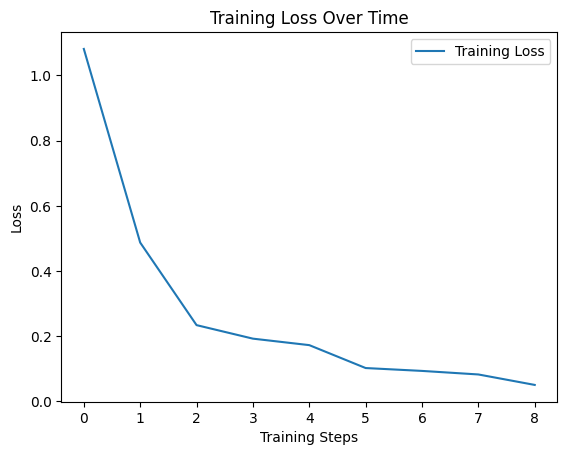

In [ ]:
import matplotlib.pyplot as plt

metrics = trainer.evaluate(val_dataset)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

# Accessing training metrics from the Trainer object
train_metrics = trainer.state.log_history

# Extract the training loss values from the training metrics if available
train_loss_values = [metrics.get('loss', None) for metrics in train_metrics]

# Filter out None values (e.g., if loss is not logged for some training steps)
train_loss_values = [loss for loss in train_loss_values if loss is not None]

# Plot the loss over time
plt.plot(train_loss_values, label='Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

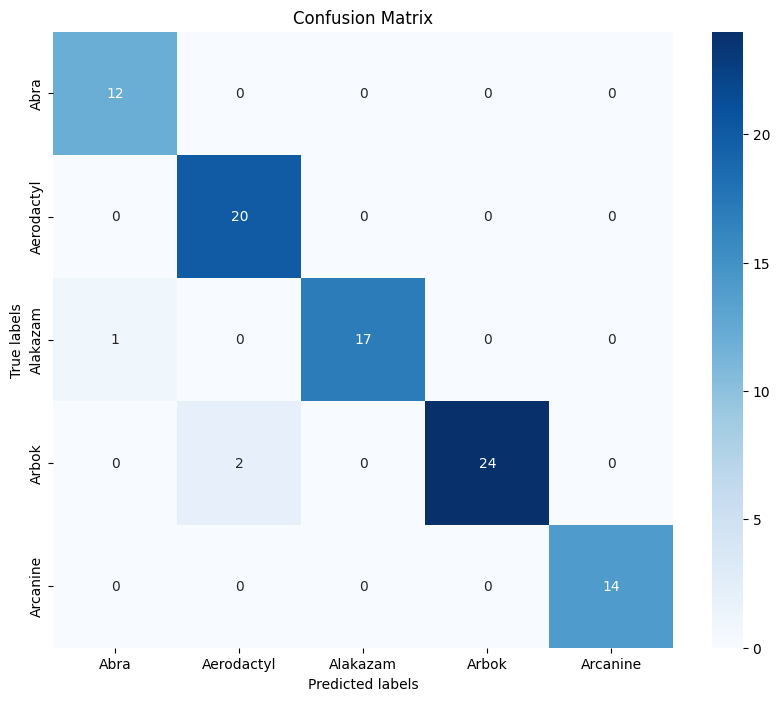

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions on the validation dataset
predictions = trainer.predict(val_dataset)

# Extract predicted labels
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Extract true labels
true_labels = [example[1] for example in val_dataset]

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from transformers import ViTForImageClassification
labels = dataset.classes

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=8,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=3e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset= train_dataset,
    eval_dataset= val_dataset,
    tokenizer=processor,
)

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.049200,0.205260,0.933333,0.924999,0.931441,0.927048


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


***** train metrics *****
  epoch                    =         8.0
  total_flos               = 207855301GF
  train_loss               =      0.1636
  train_runtime            =  0:01:34.77
  train_samples_per_second =      30.388
  train_steps_per_second   =       1.941


***** eval metrics *****
  epoch                   =        8.0
  eval_accuracy           =     0.9333
  eval_f1                 =      0.927
  eval_loss               =     0.2053
  eval_precision          =      0.925
  eval_recall             =     0.9314
  eval_runtime            = 0:00:02.07
  eval_samples_per_second =     43.347
  eval_steps_per_second   =       5.78


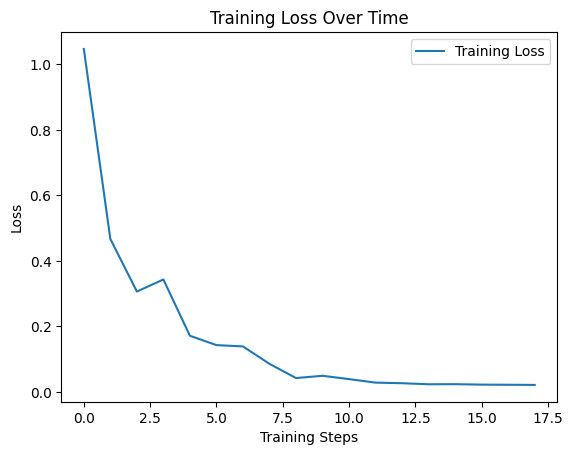

In [ ]:
import matplotlib.pyplot as plt

metrics = trainer.evaluate(val_dataset)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

# Accessing training metrics from the Trainer object
train_metrics = trainer.state.log_history

# Extract the training loss values from the training metrics if available
train_loss_values = [metrics.get('loss', None) for metrics in train_metrics]

# Filter out None values (e.g., if loss is not logged for some training steps)
train_loss_values = [loss for loss in train_loss_values if loss is not None]

# Plot the loss over time
plt.plot(train_loss_values, label='Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

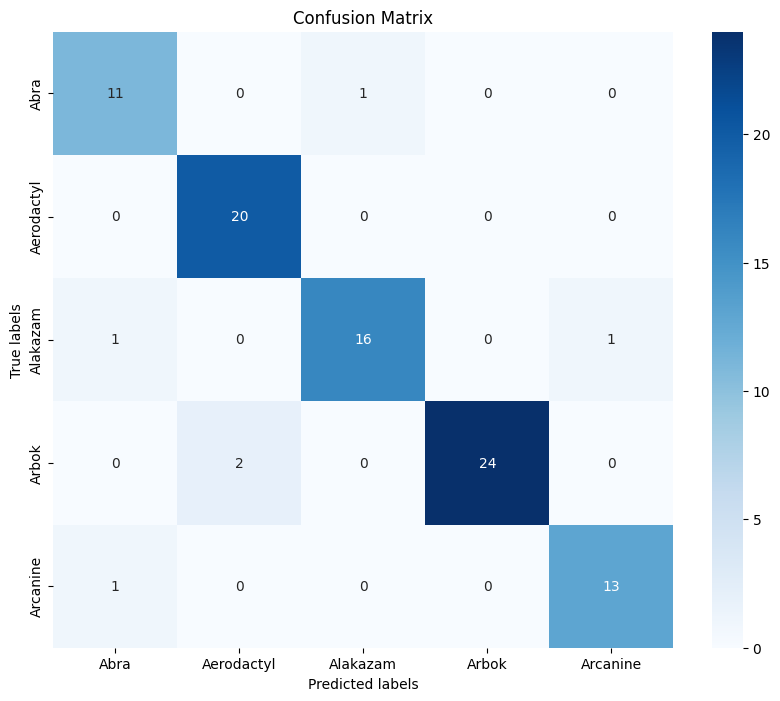

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions on the validation dataset
predictions = trainer.predict(val_dataset)

# Extract predicted labels
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Extract true labels
true_labels = [example[1] for example in val_dataset]

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()